In [1]:
import requests
import pandas as pd
import numpy as np
import sys
import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
link = 'https://api.covidactnow.org/v2/county/CA.timeseries.csv?apiKey=6b402fb107d14cac9ecf93a83992bc49'

cc_data = pd.read_csv(link)

cc_data = pd.DataFrame(cc_data)

cc_data.head()

,date,country,state,county,fips,lat,long,locationId,actuals.cases,actuals.deaths,actuals.positiveTests,actuals.negativeTests,actuals.contactTracers,actuals.hospitalBeds.capacity,actuals.hospitalBeds.currentUsageTotal,actuals.hospitalBeds.currentUsageCovid,unused1,actuals.icuBeds.capacity,actuals.icuBeds.currentUsageTotal,actuals.icuBeds.currentUsageCovid,unused2,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,actuals.vaccinationsCompleted,metrics.testPositivityRatio,metrics.testPositivityRatioDetails,metrics.caseDensity,metrics.contactTracerCapacityRatio,metrics.infectionRate,metrics.infectionRateCI90,unused3,unused4,metrics.icuCapacityRatio,riskLevels.overall,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,actuals.newDeaths,actuals.vaccinesAdministered,riskLevels.caseDensity,cdcTransmissionLevel
0,2020-03-01,US,CA,Alameda County,6001,NaN,NaN,iso1:us#iso2:us-ca#fips:06001,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,3
1,2020-03-02,US,CA,Alameda County,6001,NaN,NaN,iso1:us#iso2:us-ca#fips:06001,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.118,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,0,3
2,2020-03-03,US,CA,Alameda County,6001,NaN,NaN,iso1:us#iso2:us-ca#fips:06001,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.111,NaN,0.0,NaN,1.17,1.03,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,0,3
3,2020-03-04,US,CA,Alameda County,6001,NaN,NaN,iso1:us#iso2:us-ca#fips:06001,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.065,NaN,0.0,NaN,1.18,0.85,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,0,1
4,2020-03-05,US,CA,Alameda County,6001,NaN,NaN,iso1:us#iso2:us-ca#fips:06001,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.065,NaN,0.0,NaN,1.20,0.80,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,0,1


In [3]:
county_df = cc_data
county_df.drop(columns = ['lat', 'long', 'locationId', 'actuals.negativeTests', 'actuals.contactTracers', 'actuals.hospitalBeds.capacity',
                          'actuals.hospitalBeds.currentUsageTotal', 'actuals.hospitalBeds.currentUsageCovid', 'unused1', 'actuals.icuBeds.capacity',
                          'actuals.icuBeds.currentUsageTotal', 'actuals.icuBeds.currentUsageCovid', 'unused2', 'metrics.testPositivityRatio',
                          'metrics.testPositivityRatioDetails', 'metrics.caseDensity', 'metrics.contactTracerCapacityRatio', 'metrics.infectionRate',
                          'metrics.infectionRateCI90', 'unused3', 'unused4', 'metrics.icuCapacityRatio', 'riskLevels.overall', 
                          'metrics.vaccinationsInitiatedRatio', 'metrics.vaccinationsCompletedRatio', 'riskLevels.caseDensity', 'cdcTransmissionLevel'], inplace = True)

county_df.rename(columns = {'actuals.cases':'cases', 'actuals.deaths':'deaths', 'actuals.vaccinationsCompleted':'vaccinations'}, inplace=True)

county_df

,date,country,state,county,fips,cases,deaths,actuals.positiveTests,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,vaccinations,actuals.newDeaths,actuals.vaccinesAdministered
0,2020-03-01,US,CA,Alameda County,6001,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-02,US,CA,Alameda County,6001,1.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN
2,2020-03-03,US,CA,Alameda County,6001,2.0,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN
3,2020-03-04,US,CA,Alameda County,6001,2.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN
4,2020-03-05,US,CA,Alameda County,6001,2.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37460,2021-12-09,US,CA,Yuba County,6115,11348.0,92.0,NaN,0.0,NaN,38729.0,34836.0,1.0,76782.0
37461,2021-12-10,US,CA,Yuba County,6115,11376.0,92.0,NaN,28.0,NaN,38763.0,34904.0,0.0,77080.0
37462,2021-12-11,US,CA,Yuba County,6115,11376.0,92.0,NaN,0.0,NaN,38788.0,34941.0,0.0,77203.0
37463,2021-12-12,US,CA,Yuba County,6115,11376.0,92.0,NaN,0.0,NaN,38799.0,34971.0,0.0,77282.0


In [4]:
county_df = county_df[county_df['date'] >= '2021-01-06']
county_df = county_df[county_df['date'] <= '2021-11-27']

In [5]:
county_df['cases'] = county_df['cases'].interpolate(limit_area = 'inside')
county_df['deaths'] = county_df['deaths'].interpolate(limit_area = 'inside')
county_df['vaccinations'] = county_df['vaccinations'].interpolate(imit_area = 'inside')

In [6]:
dailyvax = county_df.copy()
dailyvax['Daily_Vax'] = (
    dailyvax.groupby(['county'])['vaccinations']
    .transform(lambda s: s.sub(s.shift().fillna(0)).abs())
)

In [7]:
movingavg = dailyvax.Daily_Vax.rolling(window=7).mean().round().fillna(0)
dailyvax['Moving_7_Day_Avg'] = movingavg

In [8]:
groupdf = dailyvax.groupby('county')

gbdf = [groupdf.get_group(x) for x in groupdf.groups]

gbdf[1]

,date,country,state,county,fips,cases,deaths,actuals.positiveTests,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,vaccinations,actuals.newDeaths,actuals.vaccinesAdministered,Daily_Vax,Moving_7_Day_Avg
935,2021-01-06,US,CA,Alpine County,6003,70.0,0.0,NaN,2.0,NaN,70.0,1.0,0.0,71.0,1.0,577.0
936,2021-01-07,US,CA,Alpine County,6003,70.0,0.0,NaN,0.0,NaN,78.0,1.0,0.0,79.0,0.0,478.0
937,2021-01-08,US,CA,Alpine County,6003,70.0,0.0,NaN,0.0,NaN,80.0,3.0,0.0,83.0,2.0,368.0
938,2021-01-09,US,CA,Alpine County,6003,70.0,0.0,NaN,0.0,NaN,80.0,4.0,0.0,84.0,1.0,253.0
939,2021-01-10,US,CA,Alpine County,6003,70.0,0.0,NaN,0.0,NaN,80.0,4.0,0.0,84.0,0.0,251.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2021-11-23,US,CA,Alpine County,6003,106.0,0.0,NaN,0.0,NaN,821.0,709.0,0.0,1713.0,0.0,1.0
1257,2021-11-24,US,CA,Alpine County,6003,106.0,0.0,NaN,0.0,NaN,821.0,709.0,0.0,1714.0,0.0,0.0
1258,2021-11-25,US,CA,Alpine County,6003,106.0,0.0,NaN,0.0,NaN,821.0,709.0,0.0,1714.0,0.0,0.0
1259,2021-11-26,US,CA,Alpine County,6003,106.0,0.0,NaN,0.0,NaN,821.0,709.0,0.0,1715.0,0.0,0.0


In [9]:
clist = list(set(list(county_df['county'])))

clist = sorted(clist)
print(clist)

d = {}
i = 0

for x in clist:
  d[x] = gbdf[i]
  i += 1

d['San Diego County']

['Alameda County', 'Alpine County', 'Amador County', 'Butte County', 'Calaveras County', 'Colusa County', 'Contra Costa County', 'Del Norte County', 'El Dorado County', 'Fresno County', 'Glenn County', 'Humboldt County', 'Imperial County', 'Inyo County', 'Kern County', 'Kings County', 'Lake County', 'Lassen County', 'Los Angeles County', 'Madera County', 'Marin County', 'Mariposa County', 'Mendocino County', 'Merced County', 'Modoc County', 'Mono County', 'Monterey County', 'Napa County', 'Nevada County', 'Orange County', 'Placer County', 'Plumas County', 'Riverside County', 'Sacramento County', 'San Benito County', 'San Bernardino County', 'San Diego County', 'San Francisco County', 'San Joaquin County', 'San Luis Obispo County', 'San Mateo County', 'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County', 'Shasta County', 'Sierra County', 'Siskiyou County', 'Solano County', 'Sonoma County', 'Stanislaus County', 'Sutter County', 'Tehama County', 'Trinity County', 'Tulare Coun

,date,country,state,county,fips,cases,deaths,actuals.positiveTests,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,vaccinations,actuals.newDeaths,actuals.vaccinesAdministered,Daily_Vax,Moving_7_Day_Avg
23545,2021-01-06,US,CA,San Diego County,6073,176725.0,1691.0,NaN,3815.0,NaN,71896.0,3757.0,37.0,75645.0,3757.0,1351.0
23546,2021-01-07,US,CA,San Diego County,6073,180575.0,1738.0,NaN,3850.0,NaN,75541.0,6021.0,47.0,81598.0,2264.0,1500.0
23547,2021-01-08,US,CA,San Diego County,6073,185125.0,1771.0,NaN,4550.0,NaN,79903.0,9941.0,33.0,89933.0,3920.0,1901.0
23548,2021-01-09,US,CA,San Diego County,6073,188663.0,1824.0,NaN,3538.0,NaN,81979.0,11518.0,53.0,93614.0,1577.0,1969.0
23549,2021-01-10,US,CA,San Diego County,6073,191951.0,1857.0,NaN,3288.0,NaN,82799.0,12657.0,33.0,95606.0,1139.0,2125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23866,2021-11-23,US,CA,San Diego County,6073,404269.0,4317.0,NaN,1385.0,NaN,2715080.0,2366966.0,0.0,5168396.0,4544.0,3575.0
23867,2021-11-24,US,CA,San Diego County,6073,404771.0,4319.0,NaN,502.0,NaN,2723474.0,2371004.0,2.0,5187718.0,4038.0,3547.0
23868,2021-11-25,US,CA,San Diego County,6073,404771.0,4319.0,NaN,0.0,NaN,2723742.0,2371166.0,0.0,5188249.0,162.0,2999.0
23869,2021-11-26,US,CA,San Diego County,6073,404771.0,4319.0,NaN,0.0,NaN,2729220.0,2373635.0,0.0,5200532.0,2469.0,2744.0


In [10]:
listy = []
for x in d:
  listy.append(x)

In [11]:
popList = [1680480,
1209,
40446,
196880,
46319,
21805,
1159540,
27956,
197037,
1013400,
29245,
134186,
180599,
18225,
913090,
156056,
64524,
30483,
9969510,
158217,
257154,
16799,
85445,
284738,
8923,
14526,
434283,
135654,
100249,
3175130,
410327,
18939,
2520060,
1578680,
65490,
2206750,
3347270,
883255,
781462,
282625,
762357,
447937,
1918880,
271957,
180822,
3021,
43517,
451479,
485722,
555728,
98217,
67216,
11721,
469407,
54660,
841734,
221264,
80890]

In [12]:
 countydict = {listy[i]: popList[i] for i in range(0, len(listy), 1)}

In [13]:
countydict['Alpine County']

1209

In [14]:
for x in d:
  d[x]['population'] = countydict[x]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
d['San Diego County']

,date,country,state,county,fips,cases,deaths,actuals.positiveTests,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,vaccinations,actuals.newDeaths,actuals.vaccinesAdministered,Daily_Vax,Moving_7_Day_Avg,population
23545,2021-01-06,US,CA,San Diego County,6073,176725.0,1691.0,NaN,3815.0,NaN,71896.0,3757.0,37.0,75645.0,3757.0,1351.0,3347270
23546,2021-01-07,US,CA,San Diego County,6073,180575.0,1738.0,NaN,3850.0,NaN,75541.0,6021.0,47.0,81598.0,2264.0,1500.0,3347270
23547,2021-01-08,US,CA,San Diego County,6073,185125.0,1771.0,NaN,4550.0,NaN,79903.0,9941.0,33.0,89933.0,3920.0,1901.0,3347270
23548,2021-01-09,US,CA,San Diego County,6073,188663.0,1824.0,NaN,3538.0,NaN,81979.0,11518.0,53.0,93614.0,1577.0,1969.0,3347270
23549,2021-01-10,US,CA,San Diego County,6073,191951.0,1857.0,NaN,3288.0,NaN,82799.0,12657.0,33.0,95606.0,1139.0,2125.0,3347270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23866,2021-11-23,US,CA,San Diego County,6073,404269.0,4317.0,NaN,1385.0,NaN,2715080.0,2366966.0,0.0,5168396.0,4544.0,3575.0,3347270
23867,2021-11-24,US,CA,San Diego County,6073,404771.0,4319.0,NaN,502.0,NaN,2723474.0,2371004.0,2.0,5187718.0,4038.0,3547.0,3347270
23868,2021-11-25,US,CA,San Diego County,6073,404771.0,4319.0,NaN,0.0,NaN,2723742.0,2371166.0,0.0,5188249.0,162.0,2999.0,3347270
23869,2021-11-26,US,CA,San Diego County,6073,404771.0,4319.0,NaN,0.0,NaN,2729220.0,2373635.0,0.0,5200532.0,2469.0,2744.0,3347270


In [16]:
for x in d:
  d[x]['Vax_Rate'] = d[x]['Daily_Vax']/d[x]['population']
  #d[x] = d[x][d[x]['Case_Vax'] <= 0.02]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
for x in d:
  d[x]['Avg_Vax_Rate'] = d[x]['Moving_7_Day_Avg']/d[x]['population']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
d['San Diego County'].head()

,date,country,state,county,fips,cases,deaths,actuals.positiveTests,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,vaccinations,actuals.newDeaths,actuals.vaccinesAdministered,Daily_Vax,Moving_7_Day_Avg,population,Vax_Rate,Avg_Vax_Rate
23545,2021-01-06,US,CA,San Diego County,6073,176725.0,1691.0,NaN,3815.0,NaN,71896.0,3757.0,37.0,75645.0,3757.0,1351.0,3347270,0.001122,0.000404
23546,2021-01-07,US,CA,San Diego County,6073,180575.0,1738.0,NaN,3850.0,NaN,75541.0,6021.0,47.0,81598.0,2264.0,1500.0,3347270,0.000676,0.000448
23547,2021-01-08,US,CA,San Diego County,6073,185125.0,1771.0,NaN,4550.0,NaN,79903.0,9941.0,33.0,89933.0,3920.0,1901.0,3347270,0.001171,0.000568
23548,2021-01-09,US,CA,San Diego County,6073,188663.0,1824.0,NaN,3538.0,NaN,81979.0,11518.0,53.0,93614.0,1577.0,1969.0,3347270,0.000471,0.000588
23549,2021-01-10,US,CA,San Diego County,6073,191951.0,1857.0,NaN,3288.0,NaN,82799.0,12657.0,33.0,95606.0,1139.0,2125.0,3347270,0.000340,0.000635


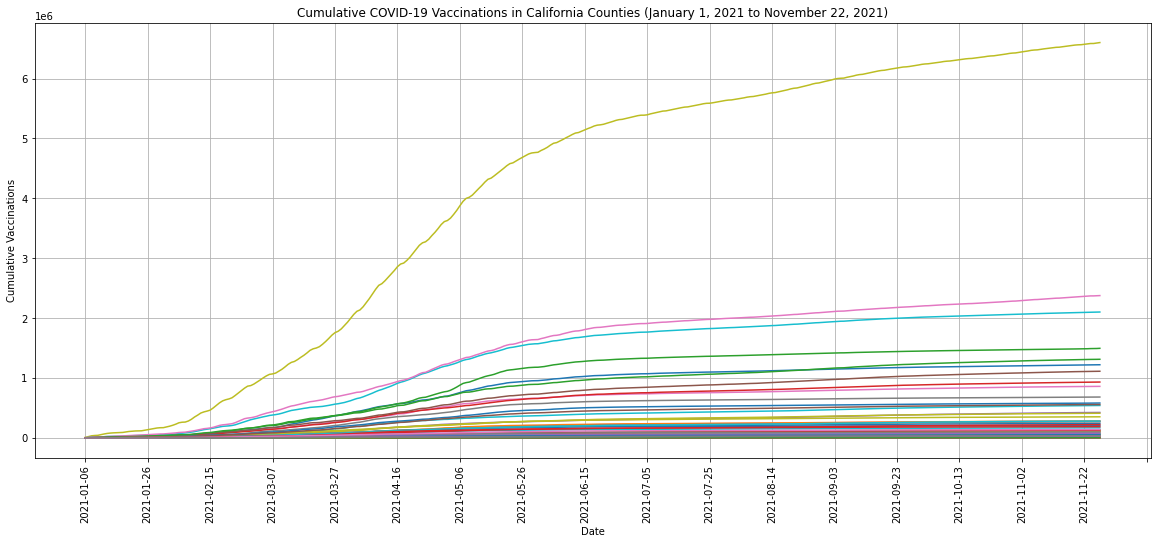

In [19]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Cases

for c in clist:
  plt.plot(d[c].date, d[c].vaccinations, label = c)
  # Create a legend for the different lines that will be displayed
  #plt.legend(c)

# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("Cumulative Vaccinations")

ticks = range(0, 350, 20)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Cumulative COVID-19 Vaccinations in California Counties (January 1, 2021 to November 22, 2021)")
plt.grid()

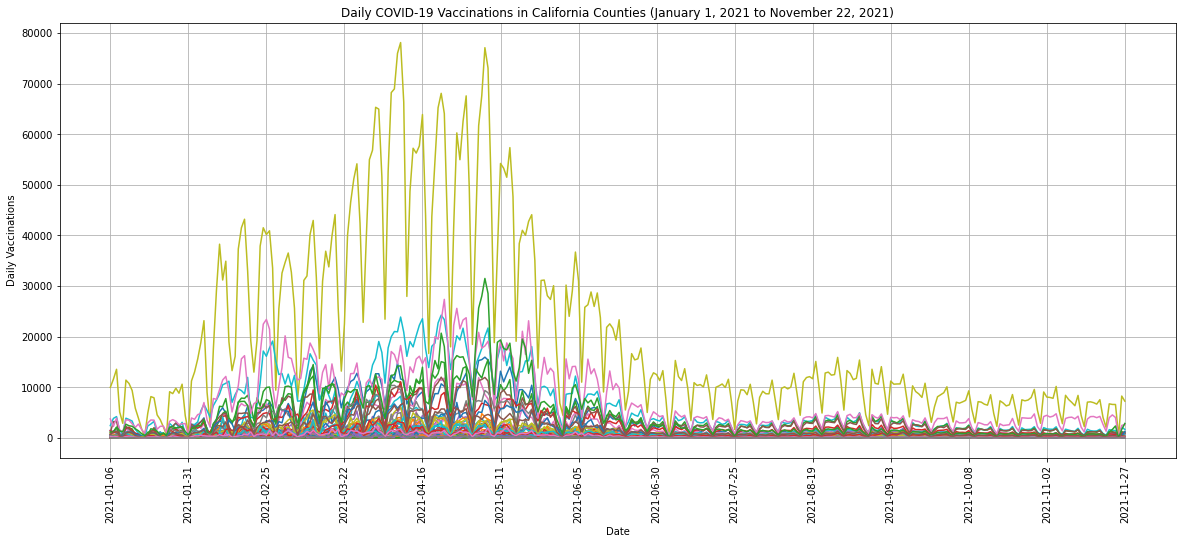

In [20]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Cases
for c in clist:
  plt.plot(d[c].date, d[c].Daily_Vax, label = c)
  #Create a legend for the different lines that will be displayed
  #plt.legend(c)

# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("Daily Vaccinations")

ticks = range(0, 350, 25)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Daily COVID-19 Vaccinations in California Counties (January 1, 2021 to November 22, 2021)")
plt.grid()

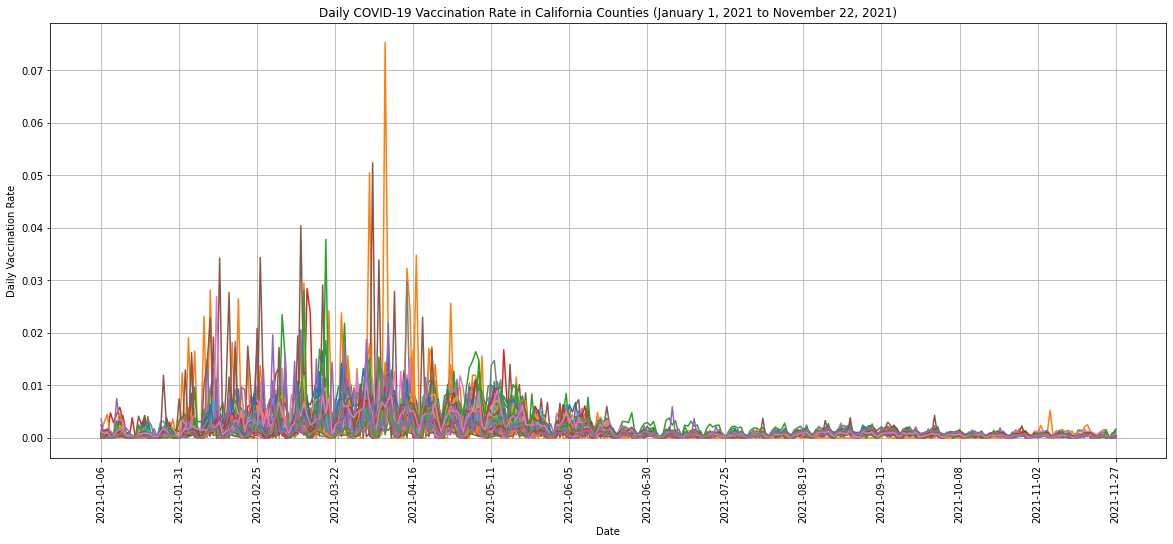

In [21]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Cases
for c in clist:
  plt.plot(d[c].date, d[c].Vax_Rate, label = c)
  #Create a legend for the different lines that will be displayed
  #plt.legend(c)



# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("Daily Vaccination Rate")

ticks = range(0, 350, 25)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Daily COVID-19 Vaccination Rate in California Counties (January 1, 2021 to November 22, 2021)")
plt.grid()

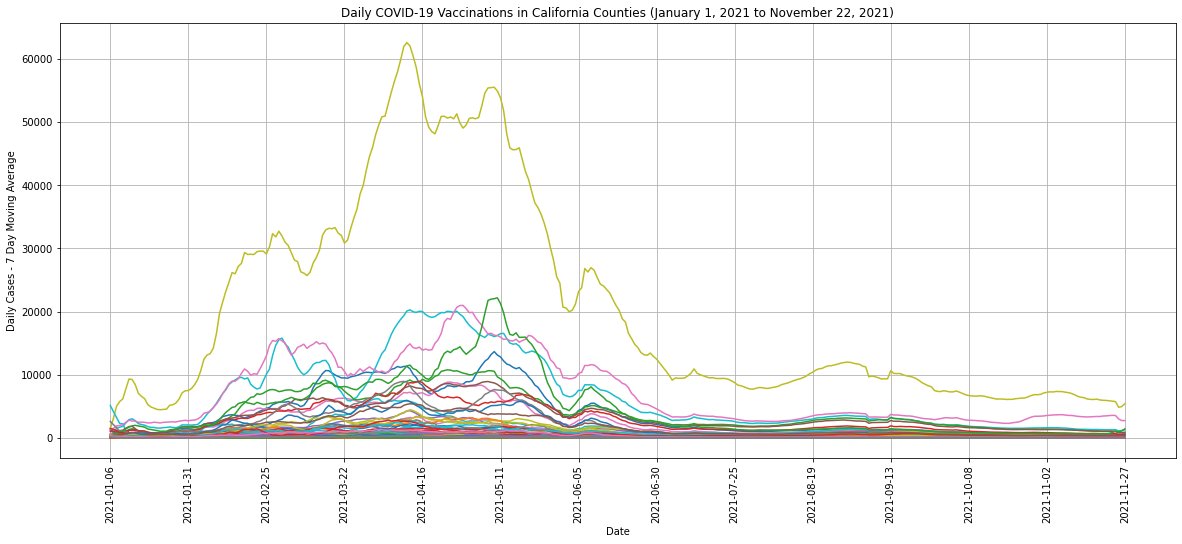

In [22]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Cases
for c in clist:
  plt.plot(d[c].date, d[c].Moving_7_Day_Avg, label = c)
  # Create a legend for the different lines that will be displayed
  # plt.legend(c)

# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("Daily Cases - 7 Day Moving Average")

ticks = range(0, 350, 25)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Daily COVID-19 Vaccinations in California Counties (January 1, 2021 to November 22, 2021)")
plt.grid()

In [23]:
la = d['Los Angeles County']
la.reset_index(inplace = True)

sd = d['San Diego County']
sd.reset_index(inplace = True)

oc = d['Orange County']
oc.reset_index(inplace = True)

rs = d['Riverside County']
rs.reset_index(inplace = True)

sb = d['San Bernardino County']
sb.reset_index(inplace = True)

santa = d['Santa Clara County']
santa.reset_index(inplace = True)

alameda = d['Alameda County']
alameda.reset_index(inplace = True)

sacramento = d['Sacramento County']
sacramento.reset_index(inplace = True)

cc = d['Contra Costa County']
cc.reset_index(inplace = True)

fc = d['Fresno County']
fc.reset_index(inplace = True)

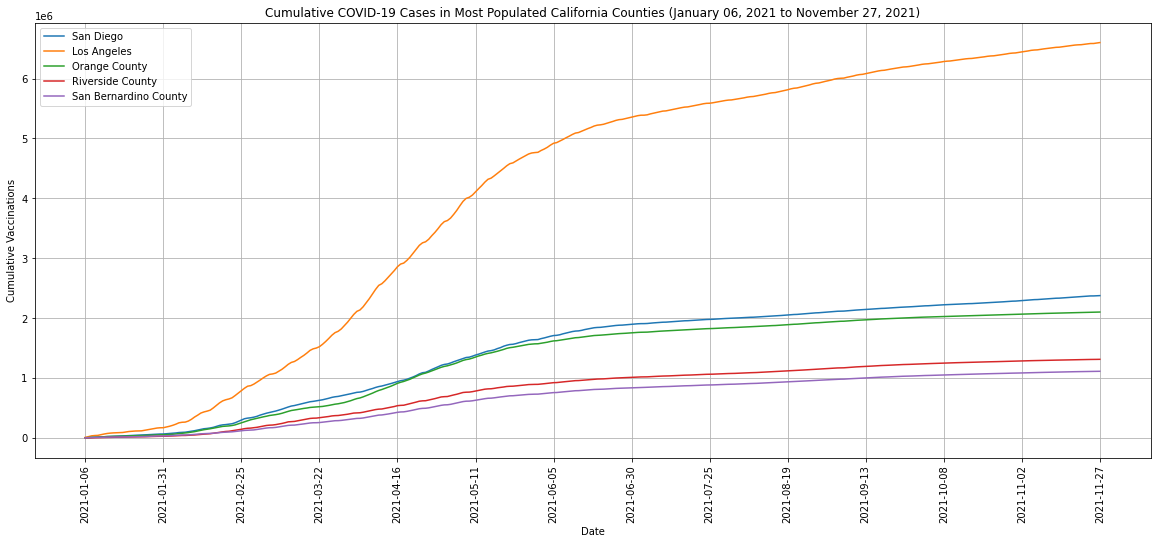

In [24]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Cases
plt.plot(sd.date, sd.vaccinations)
plt.plot(la.date, la.vaccinations)
plt.plot(oc.date, oc.vaccinations)
plt.plot(rs.date, rs.vaccinations)
plt.plot(sb.date, sb.vaccinations)

# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("Cumulative Vaccinations")

# Create a legend for the different lines that will be displayed
plt.legend(['San Diego', 'Los Angeles', 'Orange County', 'Riverside County', 'San Bernardino County'])

ticks = range(0, 350, 25)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Cumulative COVID-19 Cases in Most Populated California Counties (January 06, 2021 to November 27, 2021)")
plt.grid()

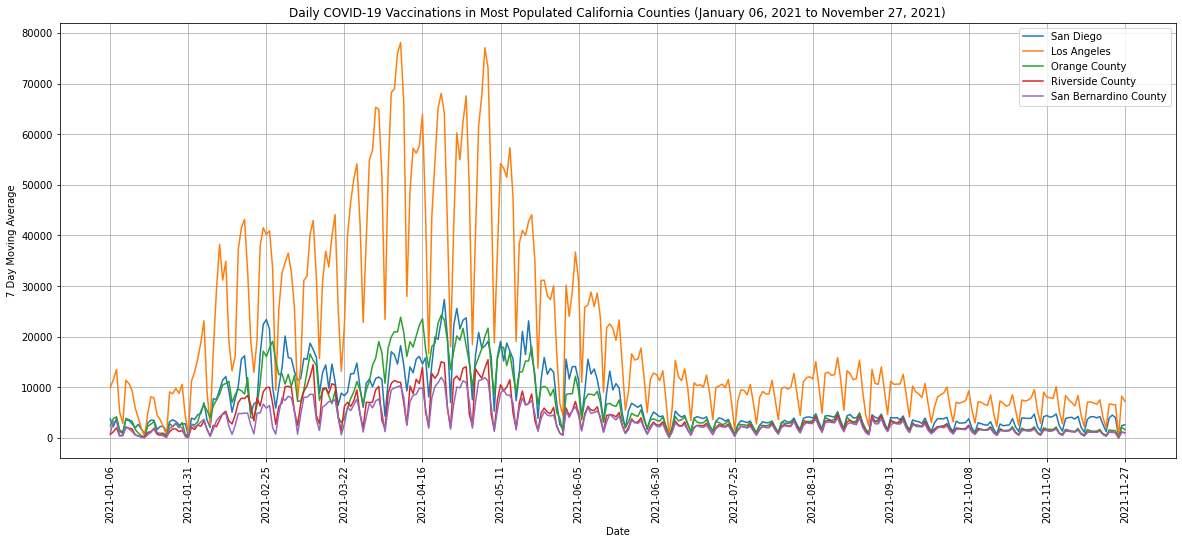

In [25]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Moving Average
plt.plot(sd.date, sd.Daily_Vax)
plt.plot(la.date, la.Daily_Vax)
plt.plot(oc.date, oc.Daily_Vax)
plt.plot(rs.date, rs.Daily_Vax)
plt.plot(sb.date, sb.Daily_Vax)

# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("7 Day Moving Average")

# Create a legend for the different lines that will be displayed
plt.legend(['San Diego', 'Los Angeles', 'Orange County', 'Riverside County', 'San Bernardino County'])

ticks = range(0, 350, 25)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Daily COVID-19 Vaccinations in Most Populated California Counties (January 06, 2021 to November 27, 2021)")
plt.grid()

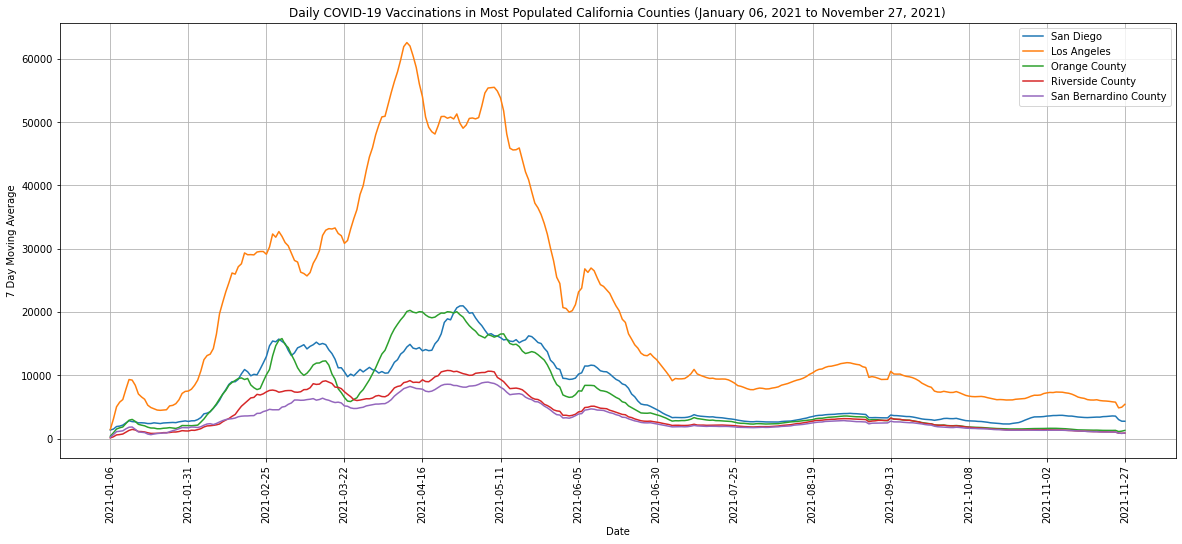

In [26]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Moving Average
plt.plot(sd.date, sd.Moving_7_Day_Avg)
plt.plot(la.date, la.Moving_7_Day_Avg)
plt.plot(oc.date, oc.Moving_7_Day_Avg)
plt.plot(rs.date, rs.Moving_7_Day_Avg)
plt.plot(sb.date, sb.Moving_7_Day_Avg)

# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("7 Day Moving Average")

# Create a legend for the different lines that will be displayed
plt.legend(['San Diego', 'Los Angeles', 'Orange County', 'Riverside County', 'San Bernardino County'])

ticks = range(0, 350, 25)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Daily COVID-19 Vaccinations in Most Populated California Counties (January 06, 2021 to November 27, 2021)")
plt.grid()

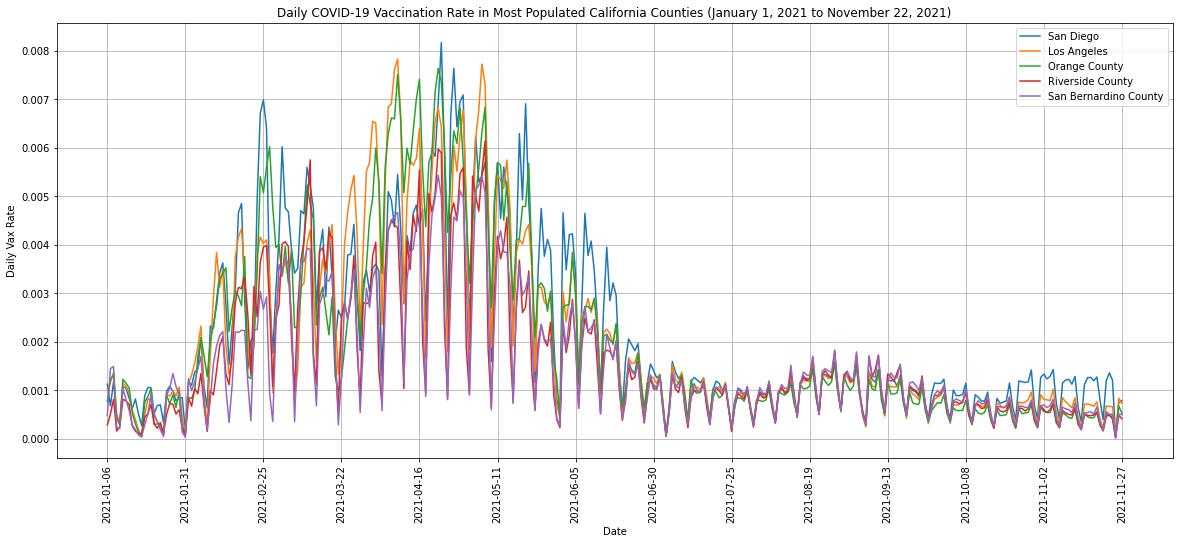

In [27]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Cases
plt.plot(sd.date, sd.Vax_Rate)
plt.plot(la.date, la.Vax_Rate)
plt.plot(oc.date, oc.Vax_Rate)
plt.plot(rs.date, rs.Vax_Rate)
plt.plot(sb.date, sb.Vax_Rate)

# Create a legend for the different lines that will be displayed
plt.legend(['San Diego', 'Los Angeles', 'Orange County', 
            'Riverside County', 'San Bernardino County'])

# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("Daily Vax Rate")

ticks = range(0, 350, 25)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Daily COVID-19 Vaccination Rate in Most Populated California Counties (January 1, 2021 to November 22, 2021)")
plt.grid()

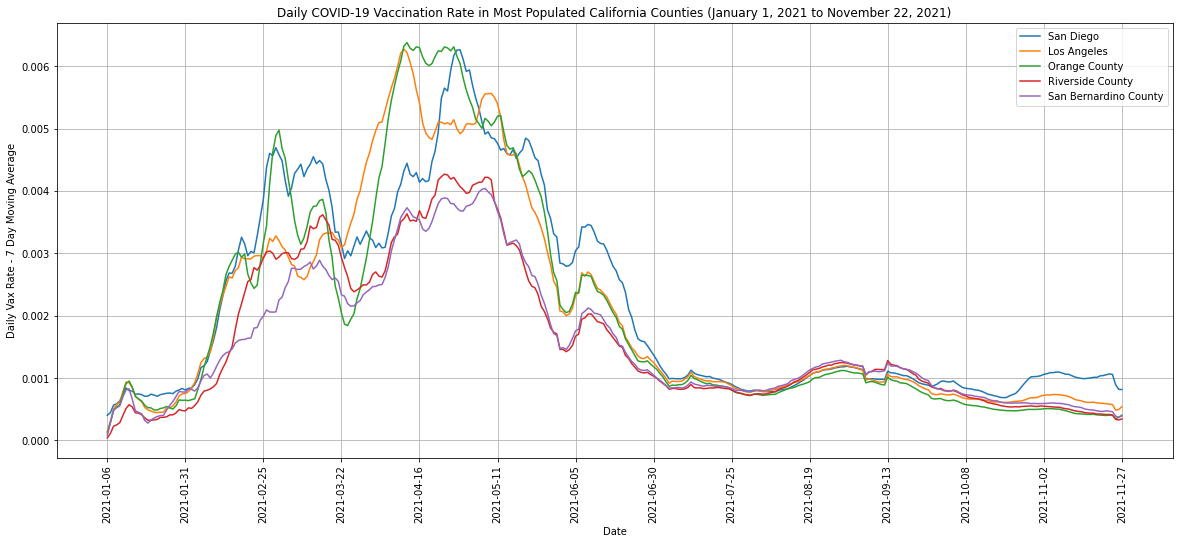

In [28]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Cases
plt.plot(sd.date, sd.Avg_Vax_Rate)
plt.plot(la.date, la.Avg_Vax_Rate)
plt.plot(oc.date, oc.Avg_Vax_Rate)
plt.plot(rs.date, rs.Avg_Vax_Rate)
plt.plot(sb.date, sb.Avg_Vax_Rate)

# Create a legend for the different lines that will be displayed
plt.legend(['San Diego', 'Los Angeles', 'Orange County', 
            'Riverside County', 'San Bernardino County'])

# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("Daily Vax Rate - 7 Day Moving Average")

ticks = range(0, 350, 25)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Daily COVID-19 Vaccination Rate in Most Populated California Counties (January 1, 2021 to November 22, 2021)")
plt.grid()

In [29]:
means = []
for x in d:
  means.append(d[x]['Vax_Rate'].mean())

In [30]:
#meansdict = {listy[i]: means[i] for i in range(0, len(listy), 1)}
mdf = pd.DataFrame()
mdf['county'] = listy
mdf['means'] = means

mdf.to_csv('County Vax Rate Means.csv', index = False)

In [33]:
from scipy import stats

print('LA: ', stats.ttest_ind(sd['Vax_Rate'].sample(n = 100, random_state = 1), la['Vax_Rate'].sample(n = 100, random_state = 1), equal_var=False))
print('OC: ', stats.ttest_ind(sd['Vax_Rate'].sample(n = 100, random_state = 1), oc['Vax_Rate'].sample(n = 100, random_state = 1), equal_var=False))
print('Riverside: ', stats.ttest_ind(sd['Vax_Rate'].sample(n = 100, random_state = 1), rs['Vax_Rate'].sample(n = 100, random_state = 1), equal_var=False))
print('San Bernardino: ', stats.ttest_ind(sd['Vax_Rate'].sample(n = 100, random_state = 1), sb['Vax_Rate'].sample(n = 100, random_state = 1), equal_var=False))
print('Santa Clara: ', stats.ttest_ind(sd['Vax_Rate'].sample(n = 100, random_state = 1), santa['Vax_Rate'].sample(n = 100, random_state = 1), equal_var=False))
print('Alameda: ', stats.ttest_ind(sd['Vax_Rate'].sample(n = 100, random_state = 1), alameda['Vax_Rate'].sample(n = 100, random_state = 1), equal_var=False))
print('Sacramento: ', stats.ttest_ind(sd['Vax_Rate'].sample(n = 100, random_state = 1), sacramento['Vax_Rate'].sample(n = 100, random_state = 1), equal_var=False))
print('Contra Costa: ', stats.ttest_ind(sd['Vax_Rate'].sample(n = 100, random_state = 1), cc['Vax_Rate'].sample(n = 100, random_state = 1), equal_var=False))
print('Fresno: ', stats.ttest_ind(sd['Vax_Rate'].sample(n = 100, random_state = 1), fc['Vax_Rate'].sample(n = 100, random_state = 1), equal_var=False))

LA:  Ttest_indResult(statistic=0.2539617534353576, pvalue=0.7997900606240029)
OC:  Ttest_indResult(statistic=0.4655185281055482, pvalue=0.6420742894978068)
Riverside:  Ttest_indResult(statistic=2.4414718981625367, pvalue=0.015557541670815698)
San Bernardino:  Ttest_indResult(statistic=2.640099254454581, pvalue=0.009010145896757192)
Santa Clara:  Ttest_indResult(statistic=-0.8686550085592811, pvalue=0.3862752279394255)
Alameda:  Ttest_indResult(statistic=-0.4416812279596447, pvalue=0.6592440815070639)
Sacramento:  Ttest_indResult(statistic=1.3118098866045989, pvalue=0.19112359640887436)
Contra Costa:  Ttest_indResult(statistic=-0.5169187769804565, pvalue=0.6058440789958688)
Fresno:  Ttest_indResult(statistic=1.7184789700393235, pvalue=0.08727239744309712)


A small p (≤ 0.05), reject the null hypothesis. This is strong evidence that the null hypothesis is invalid.
A large p (> 0.05) means the alternate hypothesis is weak, so you do not reject the null.

*   LA - do not reject null
*   OC - do not reject null
*   Riverside - reject the null
*   San Bernardino - reject the null
*   Santa Clara - do not reject the null
*   Alameda - do not reject the null
*   Sacramento - do not reject the null
*   Contra Costa - do not reject the null
*   Fresno - do not reject the null

In [32]:
#link2 = 'https://api.covidactnow.org/v2/counties.timeseries.csv?apiKey=6b402fb107d14cac9ecf93a83992bc49'

#county_data = pd.read_csv(link2)

#county_data